In [ ]:
# Nate Brunacini, nbrunaci@u.rochester.edu
# Supervisor: Kelly A. Douglass
# This file includes methods to find the gradient (slope of the trend line) of the 3D (or "R") metallicities of 
# each spaxel in a MaNGA galaxy and to create a scatter plot of those gradient values.

In [1]:
# Import packages
from astropy.io import fits
import deproject_spaxel as dps
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.table import Table
from scipy.stats import linregress
from scipy.optimize import curve_fit
import fit_functions as ff
import os

import marvin
from marvin.tools.maps import Maps

/home/nbrunaci/.local/lib/python3.8/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR17
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/nbrunaci/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


In [2]:
# Takes in plateifu and table of kinematic center data, returns coordinates of kinematic center of galaxy
def getKinematicCenter(plateifu,c_table):
    plate, ifu = plateifu.split('-')
    bool_index = np.logical_and(c_table['MaNGA_plate'] == int(plate), c_table['MaNGA_IFU'] == int(ifu))
    x_coord = c_table['x0_map'][bool_index].data[0]
    y_coord = c_table['y0_map'][bool_index].data[0]
    return (y_coord,x_coord)
    
# x0_map,y0_map: pass in as (y,x); same as (row,column)

# Returns coordinates of photometric center of the galaxy with the given plateifu
def getPhotometricCenter(plateifu):
    maps = Maps(plateifu)
#     print(maps.datamodel)
    gfluxmap = maps['spx_mflux']
    center = np.unravel_index(np.argmax(gfluxmap.data),gfluxmap.shape)
    return center

In [26]:
# Takes in plateifu, data from drpall file, and table of kinematic centers, generates lists of normalized radius from galactic center and metallicity values, and outputs them in a dictionary
def radius_lists(plateifu,drp,c_table):
    
    plate = plateifu.split('-')[0]
    q0 = 0.2
    
    metall_filename = 'MetallicityFITS_Pilyugin_DR17_v3_Final/'+plate+'/'+plateifu+'_Pilyugin_DR17_v3.fits'
    
    if not os.path.isfile(metall_filename):
        print('here')
        return None
    
    with fits.open(metall_filename, mode='update') as hdul:
        index = np.where(drp['PLATEIFU'] == plateifu)[0][0]# Index of galaxy with the given plateifu; there is only one value but it is nested, hence the [0][0]
        
        if drp['MNGTARG1'][index] <= 0:
            return None
        
        rot_angle = drp['NSA_ELPETRO_PHI'][index] * math.pi/180# Rotation angle; converted from degrees to radians        
        axisRatio = drp['NSA_ELPETRO_BA'][index]# Ratio of axes; semiminor to semimajor
        
        if axisRatio < 0:
            return None
        
#         # Temporary; for debugging purposes
#         duds = np.where(drp['NSA_ELPETRO_BA']==-9999)
#         print('Number of duds:',len(duds[0]))
#         for dud in duds[0]:
#             print(dud)
#         print('This axisRatio value is causing a NaN:',axisRatio)
        
        # Calculate angle of inclination
        cosi2 = (axisRatio**2 - q0**2)/(1 - q0**2)
        if cosi2 < 0:
            cosi2 = 0
        inc_angle = np.arccos(np.sqrt(cosi2))
        
        re = drp['NSA_ELPETRO_TH50_R'][index]# 50% light radius in SDSS r-band (in arcsec)
        
#         # Get the kinematic center of the galaxy; if there is none in the data file, use photometric center
#         center = getKinematicCenter(plateifu,c_table)
#         if center == -99.0:# No kinematic center if value is -99
#             center = getPhotometricCenter(plateifu)
        # Get the photometric center of the galaxy; NOTE: No longer using kinematic centers due to lack of data
        center = getPhotometricCenter(plateifu)
        
        # Arrays of values to be plotted
        radii_R = ma.array(np.zeros(hdul[1].shape),mask=hdul[3].data)# List of normalized radii between each spaxel and the galactic center for spaxels with R metallicity values
        R = ma.array(hdul[1].data,mask=hdul[3].data)# List of R metallicity values excluding those at masked spaxels
        ivars = ma.array(hdul[2].data,mask=hdul[3].data)# List of inverse variance values excluding those at masked spaxels
        
        # Add points to lists
        for i in range(hdul[1].shape[0]):
            for j in range(hdul[1].shape[1]):# (i,j) is actually (y,x)
                # Calcuate deprojected radius for the spaxel
                coords = (i,j)
                rad_spax,_ = dps.deproject_spaxel(coords,center,rot_angle,inc_angle)#Radius in units of spaxels
                rad_arcsec = rad_spax * 0.5# Radius in arcseconds
#                 rad_normalized = rad_arcsec/re
#                 radii_R.data[col,row] = rad_arcsec/re# WRONG
                radii_R.data[i,j] = rad_arcsec/re
    
    return {
            'radii_R': radii_R.compressed(),
            'R': R.compressed(),
            'ivars': ivars.compressed(),
            'r50':re
        }

In [27]:
# Linear Model Function. For use by curve_fit in the calculate_fits function
# WARNING: If changing this function or using a different model function, must change the corresponding function 
# in fit_functions.py
def lmf(x,m,b):
    return m*x+b

In [28]:
# Takes in dictionary of radius and metallicity lists such as that output by the radius_lists function and outputs the parameters of the line of best fit
def calculate_fits(r_lists):
    
    # Calculate slope, y-intercept, and covariance matrix using 1/ivars as weights
    # If using a model function other than lmf, must change the corresponding function in fit_functions.py
    #R_params = linregress(r_lists['radii_R'], r_lists['R'])
    R_params,covar_matrix = curve_fit(lmf,r_lists['radii_R'],r_lists['R'],sigma=1.0/ma.sqrt(r_lists['ivars']))
    
#     print(R_params)# For testing
    
    return {
        'R_params': {'slope': R_params[0], 'intercept':R_params[1]},
        'covar': covar_matrix,
        'r50':r_lists['r50']
    }

In [41]:
# Takes in output from radius_lists and calculate_fits functions as well as plateifu and plots scatter plots (metallicity 
# versus normalized radius) with lines of best fit
def scatterplots(r_lists,fit_params,plateifu):
    
    # Set up figure
    fig, plots = plt.subplots(1)
#     fig.set_figheight(5)#2.5)
    fig.set_figwidth(5)
    
    # Plot the data
#     plots.plot(r_lists['radii_R'],r_lists['R'],'.')
    plots.errorbar(r_lists['radii_R'],r_lists['R'],yerr=1.0/ma.sqrt(r_lists['ivars']),fmt='.',ecolor='lightsteelblue',zorder=0)
    
    # Set title and axis labels
#     plots.set_title(plateifu)
    plots.set_ylabel('12 + log(O/H)')
    plots.set_xlabel('$r / r_e$')
    
    # Graph trend line
    x_R = np.linspace(min(r_lists['radii_R']),max(r_lists['radii_R']))#(0.0,1.6)
    y_R = fit_params['R_params']['slope'] * x_R + fit_params['R_params']['intercept']
    dy = ff.fit_uncertainty([fit_params['R_params']['slope'],fit_params['R_params']['intercept']],fit_params['covar'],x_R)
    plots.plot(x_R,y_R,'r',zorder=1)
    plots.fill_between(x_R,y_R-dy,y_R+dy,color='mistyrose')
    
    # Set x and y limits
#     plt.xlim([0,2.75])
#     plt.ylim([8,8.8])
    ylim_lower = lmf(2.75,fit_params['R_params']['slope'],fit_params['R_params']['intercept'])
    ylim_upper = fit_params['R_params']['intercept']
    plt.ylim([ylim_lower-0.25,ylim_upper+0.25])
    
    # Show/save figure
    plt.tight_layout()
#     plt.show()# To save plots and not show them, comment this line and uncomment all lines below
#     plate = plateifu.split('-')[0]
#     foldername = #'ScatterPlots_Pilyugin_DR17_v3/'+plate+'/'
#     # Creating folder
#     if not os.path.exists(foldername):
#         os.mkdir(foldername)
#     filename = foldername+plateifu+'_Pilyugin_DR17_v3.png'
#     plt.savefig(filename,dpi=300)
#     plt.close()

    plate = plateifu.split('-')[0]
    filename = 'Thesis_Scatterplot_'+plateifu+'_Pilyugin_DR17_v3.png'
    plt.savefig(filename,dpi=500)

In [42]:
# Wrapper function to call the above functions all at once. Takes in plateifu, data from drpall file, and table of kinematic 
# centers, calculates the parameters of the line of best fit of the normalized radius versus metallicity 
# data, and creates scatter plots
def find_gradient(plateifu,drp,c_table):
    r_lists = radius_lists(plateifu,drp,c_table)
    
    if r_lists is None:
        print("NONE")
        return None
    
    trend = calculate_fits(r_lists)
    scatterplots(r_lists,trend,plateifu)
    return trend

[WARNING]: Warning: converting a masked element to nan. (UserWarning)


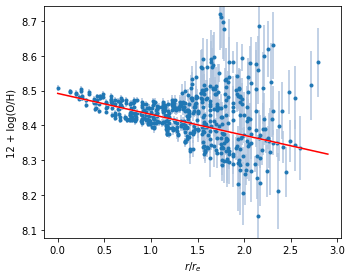

In [43]:
# Calling the functions
with fits.open('drpall-v3_1_1.fits', memmap=True) as drpall:
    c_table = Table.read('DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_noWords_v6.txt',format='ascii.commented_header')
    find_gradient('10001-12701',drpall[1].data,c_table)#('9487-12701',drpall[1].data,c_table)#('8335-12701')#('7443-12705')
#     plt.savefig('PosterMaps/Scatter_8335-12701')
# Test galaxies: 10001-12701, 9487-12701
# PROBLEM GALAXY EXAMPLE: 10141-12701

In [ ]:
# For 10001-12701:
# No weights: [-1.34782284e-05  8.43920308e+00]
# With sigma = 1/ivar: [-0.04633539  8.4820325 ]; looks like it fits well

In [61]:
testplateifu = '10143-12702'#'10141-12701'#'10001-12702'
testplate = testplateifu.split('-')[0]

with fits.open('MetallicityFITS_Pilyugin_DR17_v3/'+testplate+'/'+testplateifu+'_Pilyugin_DR17_v3.fits', mode='update') as hdul:
#     print(hdul.info())
    
#     # Mask out any spaxels that have a metallicity value of -999.0, which seems to be creating issues
#     testmask = hdul[3].data
#     for rindex,row in enumerate(testmask):
#         for vindex,val in enumerate(row):
#             if hdul[1].data[rindex][vindex] == -999:
#                 testmask[rindex][vindex] = True
    
    i = 0
    for row in hdul[1].data:
        j = 0
        for val in row:
            if not hdul[3].data[i][j] and val==-999:#(val<7 or val>10):
                print(val)
            j += 1
        i += 1
    print('Done!')
    
    # Create masked array
    R_metall_m = ma.array(hdul[1].data,mask=hdul[3].data)
#     plt.imshow(R_metall_m,origin='lower',vmin=80,vmax=90)
#     plt.locator_params(axis='y', nbins=5)
#     plt.title('3D Metallicity ('+testplateifu+') in DR17')
#     plt.xlabel('x-Distance (spaxels)')
#     plt.ylabel('y-Distance (spaxels)')
#     plt.colorbar(label='12+log(O/H)')
#     plt.tight_layout()

Done!
